In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# fetching fifa dataset 2017-2023 urls from git repository
base_url = 'https://raw.githubusercontent.com/fern-1210/IronHack-w3-Modual1-Project3/refs/heads/main/Data/Raw/FIFA%202017-2023%20data%20raw/'

fifa_files = {
    'FIFA17': f'{base_url}FIFA17_official_data.csv',
    'FIFA18': f'{base_url}FIFA18_official_data.csv',
    'FIFA19': f'{base_url}FIFA19_official_data.csv',
    'FIFA20': f'{base_url}FIFA20_official_data.csv',
    'FIFA21': f'{base_url}FIFA21_official_data.csv',
    'FIFA22': f'{base_url}FIFA22_official_data.csv',
    'FIFA23': f'{base_url}FIFA23_official_data.csv',
}

# build dictionary to store data for before compared to after metrics
datasets = {}
metrics_summary = []

for fifa_year, filepath in fifa_files.items():

    print("\n" + "="*60)
    print(f"processing {fifa_year}")
    print("="*60)

    # data initial exploration

    print(f"\nloading data from GitHub")
    print(f"Getting data from url...")
    df = pd.read_csv(filepath, encoding='utf-8', low_memory=False)
    print(f"loaded successfully")

    # store original for checking against
    df_original = df.copy()

    print(f"\nDataset Size:")
    print(f"   Rows: {len(df):,}")
    print(f"   Columns: {len(df.columns)}")

    # checking whether data is number form or categorical
    numerical_cols = df.select_dtypes(include='number').columns.tolist()
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    print(f"\ncolumn types:")
    print(f"   Numerical: {len(numerical_cols)}")
    print(f"   Categorical: {len(categorical_cols)}")

    # checking for all missing data

    print("\n" + "="*60)
    print("The missing data report")
    print("="*60)

    missing = df.isna().sum()
    missing_pct = (missing / len(df) * 100).round(2)

    missing_df = pd.DataFrame({
        'missing_count': missing,
        'missing_percentage': missing_pct
    }).sort_values('missing_percentage', ascending=False)

    print(missing_df.head(20))

    print(f"\ncolumns with >40% missing:")
    high_missing = missing_df[missing_df['missing_percentage'] > 40]
    for col in high_missing.index:
        print(f"   - {col}: {high_missing.loc[col, 'missing_percentage']:.1f}%")

    # storing before assessments
    total_missing_before = df.isna().sum().sum()
    total_cells = len(df) * len(df.columns)
    overall_missing_pct_before = (total_missing_before / total_cells) * 100

    print(f"\noverall missing data:")
    print(f"   Total Cells: {total_cells:,}")
    print(f"   Missing Cells: {total_missing_before:,}")
    print(f"   Percentage: {overall_missing_pct_before:.2f}%")

    # checking for duplicates

    print("\n" + "="*60)
    print("duplicate check")
    print("="*60)

    duplicate_rows = df.duplicated().sum()

    print(f"\ntotal rows: {len(df):,}")
    print(f"exact duplicate rows: {duplicate_rows}")

    if duplicate_rows == 0:
        print("no exact duplicate rows found")
    else:
        print(f"found {duplicate_rows} exact duplicate rows")
        print("removing duplicates...")
        df = df.drop_duplicates()
        print(f"new row count: {len(df):,}")

    # cleaning and standardising all text

    print("\n" + "="*60)
    print("standardising text columns")
    print("="*60)

    text_columns_to_clean = ['name', 'nationality', 'club', 'position',
                              'preferred Foot', 'work rate', 'body']

    for col in text_columns_to_clean:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = df[col].str.strip()
            df.loc[df[col] == 'nan', col] = np.nan

    print(f"standardised {len([c for c in text_columns_to_clean if c in df.columns])} text columns")

    # Work rate figure standardise format
    if 'Work Rate' in df.columns:
        df['Work Rate'] = df['Work Rate'].str.strip()
        df['Work Rate'] = df['Work Rate'].fillna('Medium/ Medium')

    # filling any missing values - categorical columns

    print("\n" + "="*60)
    print("filling missing values - categorical")
    print("="*60)

    categorical_fillna = {
        'Nationality': 'Unknown',
        'Club': 'Free Agent',
        'position': 'Unknown',
        'preferred Foot': 'Right',
        'work Rate': 'Medium/ Medium',
        'Body Type': 'Normal',
        'Real Face': 'No',
    }

    for col, fill_value in categorical_fillna.items():
        if col in df.columns:
            before = df[col].isna().sum()
            df[col] = df[col].fillna(fill_value)
            after = df[col].isna().sum()
            if before > 0:
                print(f"{col}: filled {before - after} values with '{fill_value}'")

    # filling missing vals for numerical columns

    print("\n" + "="*60)
    print("filling missing values - numerical")
    print("="*60)

    # rating columns and filling using defaults or using median values
    rating_cols = ['Overall', 'Potential', 'International Reputation',
                   'Weak Foot', 'Skill Moves']

    for col in rating_cols:
        if col in df.columns:
            before = df[col].isna().sum()
            if before > 0:
                if col in ['Weak Foot', 'Skill Moves']:
                    df[col] = df[col].fillna(3.0)
                    print(f"{col}: filled {before} values with 3 (default)")
                elif col == 'International Reputation':
                    df[col] = df[col].fillna(1.0)
                    print(f"{col}: filled {before} values with 1 (default)")
                else:
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                    print(f"{col}: filled {before} values with median ({median_val:.1f})")

    # working out age using median
    if 'Age' in df.columns:
        before = df['Age'].isna().sum()
        if before > 0:
            median_age = df['Age'].median()
            df['Age'] = df['Age'].fillna(median_age)
            print(f"Age: filled {before} values with median ({median_age:.0f})")

    # special using median
    if 'Special' in df.columns:
        before = df['Special'].isna().sum()
        if before > 0:
            median_special = df['Special'].median()
            df['Special'] = df['Special'].fillna(median_special)
            print(f"Special: filled {before} values with median ({median_special:.0f})")

    # filling all remaining numerical columns with median values
    remaining_numerical = [col for col in numerical_cols if col in df.columns
                          and df[col].isna().sum() > 0]

    for col in remaining_numerical:
        before = df[col].isna().sum()
        if before > 0 and before < len(df):
            median_val = df[col].median()
            if pd.notna(median_val):
                df[col] = df[col].fillna(median_val)
                print(f"{col}: filled {before} values with median ({median_val:.1f})")

    # additional enrichment for financial data assessment

    print("\n" + "="*60)
    print("filling in contract and financial data")
    print("="*60)

    # release clause filling with median based on overall rating
    if 'Release Clause' in df.columns:
        before = df['Release Clause'].isna().sum()
        if before > 0:
            try:
                # parsing Release Clause (remove € and M/K suffixes)
                def parse_Release_Clause(val):
                    if pd.isna(val):
                        return np.nan
                    val = str(val).replace('€', '').strip()
                    if 'M' in val:
                        return float(val.replace('M', '')) * 1_000_000
                    elif 'K' in val:
                        return float(val.replace('K', '')) * 1_000
                    try:
                        return float(val)
                    except:
                        return np.nan

                df['Release_Clause_Numeric'] = df['Release Clause'].apply(parse_Release_Clause)
                median_clause = df['Release_Clause_Numeric'].median()

                if pd.notna(median_clause):
                    # filling missing with median
                    df['Release_Clause_Numeric'] = df['Release_Clause_Numeric'].fillna(median_clause)

                    # changing back to string format
                    def format_Release_Clause(val):
                        if pd.isna(val):
                            return np.nan
                        if val >= 1_000_000:
                            return f"€{val/1_000_000:.1f}M"
                        elif val >= 1_000:
                            return f"€{val/1_000:.0f}K"
                        return f"€{val:.0f}"

                    df.loc[df['Release Clause'].isna(), 'Release Clause'] = df.loc[df['Release Clause'].isna(), 'Release_Clause_Numeric'].apply(format_Release_Clause)
                    df = df.drop('Release_Clause_Numeric', axis=1)

                    after = df['Release Clause'].isna().sum()
                    print(f"Release Clause: filled {before - after} values with median-based estimates")
            except Exception as e:
                print(f"Release Clause: skipped (parsing error)")


    # joined is being filling with most common year from mode value
    if 'Joined' in df.columns:
        before = df['Joined'].isna().sum()
        if before > 0:
            # Convert to string first to handle mixed types
            df['Joined'] = df['Joined'].astype(str)
            df.loc[df['Joined'] == 'nan', 'Joined'] = np.nan

            mode_year = df['Joined'].mode()
            if len(mode_year) > 0 and mode_year[0] != 'nan':
                df['Joined'] = df['Joined'].fillna(mode_year[0])
                after = df['Joined'].isna().sum()
                print(f"Joined: filled {before - after} values with mode ({mode_year[0]})")


    # Contract is valid until is also being fill with median value
    if 'Contract Valid Until' in df.columns:
        before = df['Contract Valid Until'].isna().sum()
        if before > 0:
            # convert to number and handling any string values issues
            df['Contract Valid Until'] = pd.to_numeric(df['Contract Valid Until'], errors='coerce')
            median_contract = df['Contract Valid Until'].median()
            if pd.notna(median_contract):
                df['Contract Valid Until'] = df['Contract Valid Until'].fillna(median_contract)
                after = df['Contract Valid Until'].isna().sum()
                print(f"Contract Valid Until: filled {before - after} values with median ({median_contract:.0f})")


    # loaned from filling with explicit Not on Loan value
    if 'Loaned From' in df.columns:
        before = df['Loaned From'].isna().sum()
        if before > 0:
            df['Loaned From'] = df['Loaned From'].fillna('Not on Loan')
            after = df['Loaned From'].isna().sum()
            print(f"Loaned From: filled {before - after} values with 'Not on Loan'")

    # Best Overall Rating is main;y empty remainder filled with overall rating
    if 'Best Overall Rating' in df.columns and 'Overall' in df.columns:
        before = df['Best Overall Rating'].isna().sum()
        if before > 0:
            try:
                df['Best Overall Rating'] = df['Best Overall Rating'].fillna(df['Overall'])
                after = df['Best Overall Rating'].isna().sum()
                print(f"Best Overall Rating: filled {before - after} values with Overall rating")
            except Exception as e:
                print(f"Best Overall Rating: skipped (error filling)")

    # starting the data validation process

    print("\n" + "="*60)
    print("Data validation looking at before versus after cleaning")
    print("="*60)

    # Calculating the after metrics for full assessment
    total_missing_after = df.isna().sum().sum()
    total_cells_after = len(df) * len(df.columns)
    overall_missing_pct_after = (total_missing_after / total_cells_after) * 100

    print(f"\nMissing Data Comparison:")
    print(f"Before Cleaning:")
    print(f"  Total rows: {len(df_original):,}")
    print(f"  Missing cells: {total_missing_before:,}")
    print(f"  Missing Percentage: {overall_missing_pct_before:.2f}%")

    print(f"\nAfter cleaning:")
    print(f"  Total rows: {len(df):,}")
    print(f"  Missing cells: {total_missing_after:,}")
    print(f"  Missing percentage: {overall_missing_pct_after:.2f}%")

    print(f"\nImprovement:")
    print(f"  Cells filled: {total_missing_before - total_missing_after:,}")
    print(f"  Percentage reduction: {overall_missing_pct_before - overall_missing_pct_after:.2f}%")

    # Top columns that are still with missing data
    missing_after = df.isna().sum()
    missing_after_pct = (missing_after / len(df) * 100).round(2)

    missing_df_after = pd.DataFrame({
        'missing_count': missing_after,
        'missing_percentage': missing_after_pct
    }).sort_values('missing_percentage', ascending=False)

    still_missing = missing_df_after[missing_df_after['missing_count'] > 0]

    if len(still_missing) > 0:
        print(f"\nColumns still with missing data (top 10):")
        for col in still_missing.head(10).index:
            print(f"  - {col}: {still_missing.loc[col, 'missing_count']:,} " +
                  f"({still_missing.loc[col, 'missing_percentage']:.1f}%)")
    else:
        print(f"\nNo missing data remaining")

    # storing metrics for further use
    metrics_summary.append({
        'FIFA_Year': fifa_year,
        'Rows_Before': len(df_original),
        'Rows_After': len(df),
        'Duplicates_Removed': duplicate_rows,
        'Missing_Before': total_missing_before,
        'Missing_After': total_missing_after,
        'Missing_Pct_Before': round(overall_missing_pct_before, 2),
        'Missing_Pct_After': round(overall_missing_pct_after, 2),
        'Improvement_Pct': round(overall_missing_pct_before - overall_missing_pct_after, 2),
    })


    # saving the updated and cleaned dataset - which was then uploaded to the cleaned drive in git

    print("\n" + "="*60)
    print(f"saving {fifa_year}")
    print("="*60)

    output_filename = f"{fifa_year}_cleaned.csv"

    df.to_csv(output_filename, index=False, encoding='utf-8')
    print(f"saved cleaned dataset to: {output_filename}")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")

    # Storing in new dictionary
    datasets[fifa_year] = df

    print(f"\n{fifa_year} processing complete")

# Final summary for assessment and viewing

print("\n\n" + "="*60)
print("Final summary of all FIFA data")
print("="*60)

summary_df = pd.DataFrame(metrics_summary)

print("\nProcessing of summary:")
print(summary_df.to_string(index=False))

print(f"\n\nKey achievements:")
print("-"*60)

total_rows_cleaned = summary_df['Rows_After'].sum()
total_duplicates = summary_df['Duplicates_Removed'].sum()
avg_improvement = summary_df['Improvement_Pct'].mean()

print(f"Processed {len(fifa_files)} FIFA datasets")
print(f"Total players across all years: {total_rows_cleaned:,}")
print(f"Total duplicates removed: {total_duplicates:,}")
print(f"Average missing data improvement: {avg_improvement:.2f}%")
print(f"\nAll cleaned datasets saved to current directory")

print("\n" + "="*60)
print("DATA CLEANING & ENRICHMENT COMPLETE")
print("="*60)

# Saving new summary for analysis
summary_path = "FIFA_cleaning_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\nSummary report saved to: FIFA_cleaning_summary.csv")


processing FIFA17

loading data from GitHub
Getting data from url...
loaded successfully

Dataset Size:
   Rows: 17,560
   Columns: 63

column types:
   Numerical: 44
   Categorical: 19

The missing data report
                          missing_count  missing_percentage
Loaned From                       16227               92.41
Joined                             1695                9.65
Contract Valid Until                362                2.06
Club                                243                1.38
Position                             19                0.11
Jersey Number                        19                0.11
Name                                  0                0.00
Overall                               0                0.00
Potential                             0                0.00
Club Logo                             0                0.00
ID                                    0                0.00
Photo                                 0                0.00
National

hypothesis: That left footed players have been increasing in value over time period
------------------------------------------------------------

total players loaded: 122,012

parsing player values...
Players with valid values: 119,726

average player value by Preferred foot and year
------------------------------------------------------------

2017:
  Left: €2.01M (n=4,024)
  Right: €1.95M (n=13,229)

2018:
  Left: €2.57M (n=4,112)
  Right: €2.39M (n=13,560)

2019:
  Left: €2.67M (n=4,131)
  Right: €2.45M (n=13,571)

2020:
  Left: €2.90M (n=4,000)
  Right: €2.76M (n=12,657)

2021:
  Left: €2.75M (n=4,104)
  Right: €2.59M (n=12,595)

2022:
  Left: €3.60M (n=4,014)
  Right: €3.36M (n=12,352)

2023:
  Left: €3.13M (n=3,957)
  Right: €2.68M (n=13,420)

Year-over-year growth rate
------------------------------------------------------------

left-footed players:
  2018: +28.0%
  2019: +3.9%
  2020: +8.6%
  2021: -5.1%
  2022: +30.8%
  2023: -13.2%

Right-footed players:
  2018: +22.3%
  20

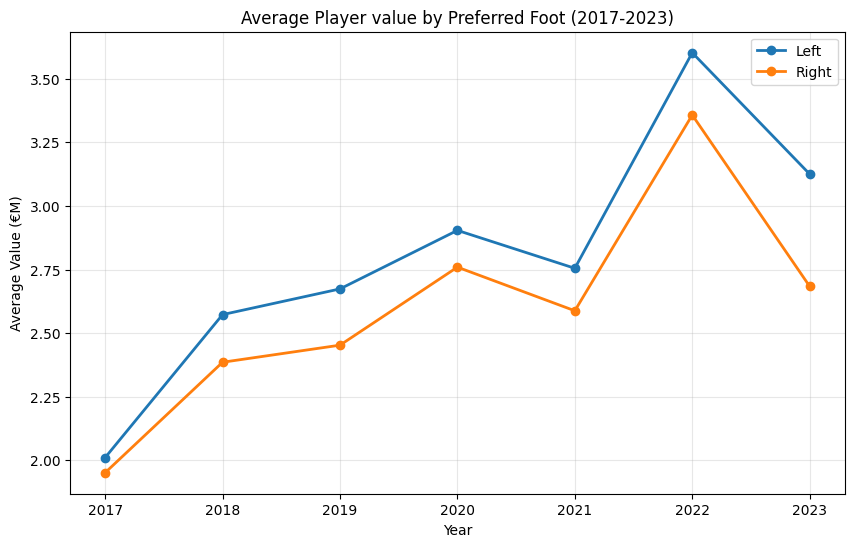

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("hypothesis: That left footed players have been increasing in value over time period")
print("-"*60)

# load all fifa datasets
fifa_files = ['FIFA17_cleaned.csv', 'FIFA18_cleaned.csv', 'FIFA19_cleaned.csv',
              'FIFA20_cleaned.csv', 'FIFA21_cleaned.csv', 'FIFA22_cleaned.csv',
              'FIFA23_cleaned.csv']

all_data = []

for file in fifa_files:
    year = file.replace('_cleaned.csv', '').replace('FIFA', '20')
    df = pd.read_csv(file)
    df['Year'] = year
    all_data.append(df)

# combining all datasets
combined_df = pd.concat(all_data, ignore_index=True)

print(f"\ntotal players loaded: {len(combined_df):,}")

# parsing the value column to numeric
def parse_value(val):
    """convert fifa value string to numeric"""
    if pd.isna(val):
        return np.nan
    val = str(val).replace('€', '').strip()
    if 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'K' in val:
        return float(val.replace('K', '')) * 1_000
    try:
        return float(val)
    except:
        return np.nan

print("\nparsing player values...")
combined_df['Value_Numeric'] = combined_df['Value'].apply(parse_value)

# remove players with no vlaue (free agents etc)
combined_df = combined_df[combined_df['Value_Numeric'] > 0]

print(f"Players with valid values: {len(combined_df):,}")

# calculating the average value by year and foot preference
print("\naverage player value by Preferred foot and year")
print("-"*60)

avg_by_foot_year = combined_df.groupby(['Year', 'Preferred Foot'])['Value_Numeric'].agg(['mean', 'count']).reset_index()

# show results
for year in sorted(avg_by_foot_year['Year'].unique()):
    year_data = avg_by_foot_year[avg_by_foot_year['Year'] == year]
    print(f"\n{year}:")
    for _, row in year_data.iterrows():
        foot = row['Preferred Foot']
        avg_value = row['mean']
        count = row['count']
        print(f"  {foot}: €{avg_value/1_000_000:.2f}M (n={count:,})")

# calculate YoY growth
print("\nYear-over-year growth rate")
print("-"*60)

left_foot = avg_by_foot_year[avg_by_foot_year['Preferred Foot'] == 'Left'].sort_values('Year')
right_foot = avg_by_foot_year[avg_by_foot_year['Preferred Foot'] == 'Right'].sort_values('Year')

left_foot['Growth_Rate'] = left_foot['mean'].pct_change() * 100
right_foot['Growth_Rate'] = right_foot['mean'].pct_change() * 100

print("\nleft-footed players:")
for _, row in left_foot.iterrows():
    if pd.notna(row['Growth_Rate']):
        print(f"  {row['Year']}: {row['Growth_Rate']:+.1f}%")

print("\nRight-footed players:")
for _, row in right_foot.iterrows():
    if pd.notna(row['Growth_Rate']):
        print(f"  {row['Year']}: {row['Growth_Rate']:+.1f}%")

# calculate overall growth 2017-2023
left_start = left_foot.iloc[0]['mean']
left_end = left_foot.iloc[-1]['mean']
left_total_growth = ((left_end - left_start) / left_start) * 100

right_start = right_foot.iloc[0]['mean']
right_end = right_foot.iloc[-1]['mean']
right_total_growth = ((right_end - right_start) / right_start) * 100

print("\nOverall growth 2017-2023")
print("-"*60)
print(f"Left-footed:  {left_total_growth:+.1f}%")
print(f"right-footed: {right_total_growth:+.1f}%")

# visualization
print("\ncreating visualization...")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# plot 1: average value over time
for foot in ['Left', 'Right']:
    data = avg_by_foot_year[avg_by_foot_year['Preferred Foot'] == foot].sort_values('Year')
    ax1.plot(data['Year'], data['mean']/1_000_000, marker='o', linewidth=2, label=foot)

ax1.set_xlabel('Year')
ax1.set_ylabel('Average Value (€M)')
ax1.set_title('Average Player value by Preferred Foot (2017-2023)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# conclusion - on left foot v right foot values 2017-23
print("\nhypothesis conclusion")
print("-"*60)

if left_total_growth > right_total_growth:
    difference = left_total_growth - right_total_growth
    print(f"\nLeft-footed players increased in value {difference:.1f}% more than right-footed players")
    print("Hypothesis supported")
else:
    difference = right_total_growth - left_total_growth
    print(f"\nRight-footed players increased in value {difference:.1f}% more than left-footed players")
    print("hypothesis not supported")

print("\n" + "-"*60)